# 06c. Time series data - Version: Monthly Average Discountdata analysis
## Notebook content:

#### PART 1: Analysing time series data
    1. Importing libraries and data
    2. Subsetting, wrangling, and cleaning time-series data
    3. Time series analysis: decomposition
    4. Testing for stationarity
    5. Stationarizing the data
    
#### PART 2: Time series forecasting
    1. Defining parameters
    2. Splitting data
    3. Running and fitting the model
    4. Iterating

## PART 1: Analysing time series data

### 1. Importing libraries and data

In [42]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear.

In [43]:
path = r'C:\Users\bruna\Data Analysis Projects\2023-12 Superstore Sales Analysis'

In [44]:
# Import the sales data
sales_clean = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'sales_clean.pkl'))

In [45]:
sales_clean.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Segment,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.0,14.1694
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [46]:
sales_clean.shape

(8113, 19)

### 2. Subsetting and smoothing time-series data

In [47]:
# Group by 'Order_Date' (month) and sum the 'Discount' values
discount_per_month = sales_clean.groupby(sales_clean['Order_Date'].dt.to_period('M'))['Discount'].mean().reset_index()

# Rename columns for clarity
discount_per_month.columns = ['Order_Month', 'Monthly_Discount']

In [48]:
discount_per_month.head()

,Order_Month,Monthly_Discount
0,2014-01,0.112500
1,2014-02,0.192857
2,2014-03,0.155639
3,2014-04,0.106696
4,2014-05,0.128500


In [49]:
discount_per_month.shape

(48, 2)

In [50]:
# Check for missing values

discount_per_month.isnull().sum() 

Order_Month         0
Monthly_Discount    0
dtype: int64

In [51]:
# Check for duplicates

dups = discount_per_month.duplicated()
dups.sum()

#No dups

0

In [52]:
# Set the "Date" column as the index

from datetime import datetime

discount_per_month['datetime'] = discount_per_month['Order_Month'].dt.to_timestamp()
discount_per_month = discount_per_month.set_index('datetime') # Set the datetime as the index of the dataframe.
discount_per_month.drop(['Order_Month'], axis=1, inplace=True) # Drop the "Order_Date" column.
discount_per_month.head()

,Monthly_Discount
datetime,
2014-01-01,0.112500
2014-02-01,0.192857
2014-03-01,0.155639
2014-04-01,0.106696
2014-05-01,0.128500


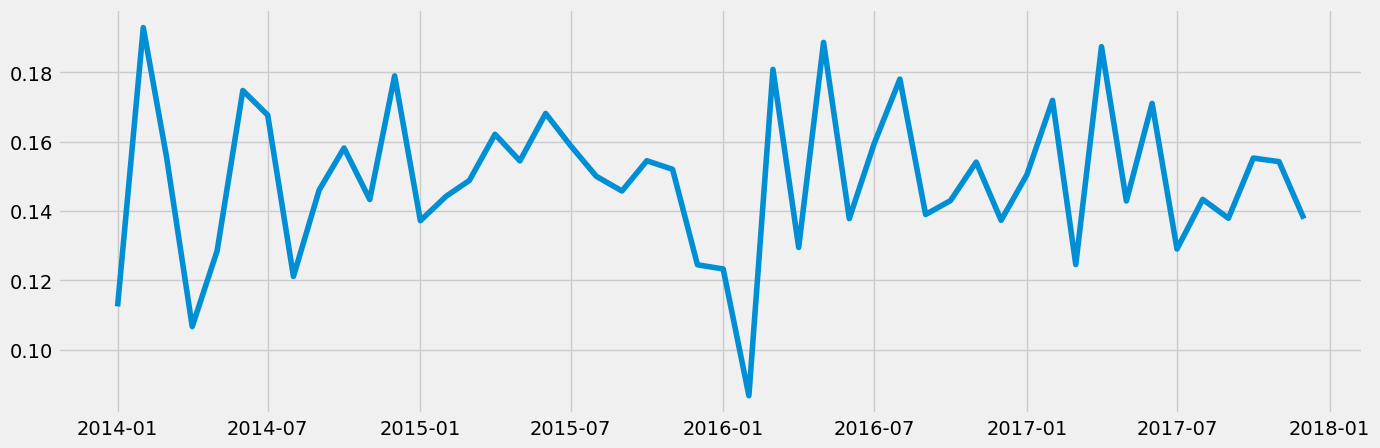

In [53]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(discount_per_month)

### 3. Time-series analysis: decomposition

In [54]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(discount_per_month, model='additive', period = 1)

In [55]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

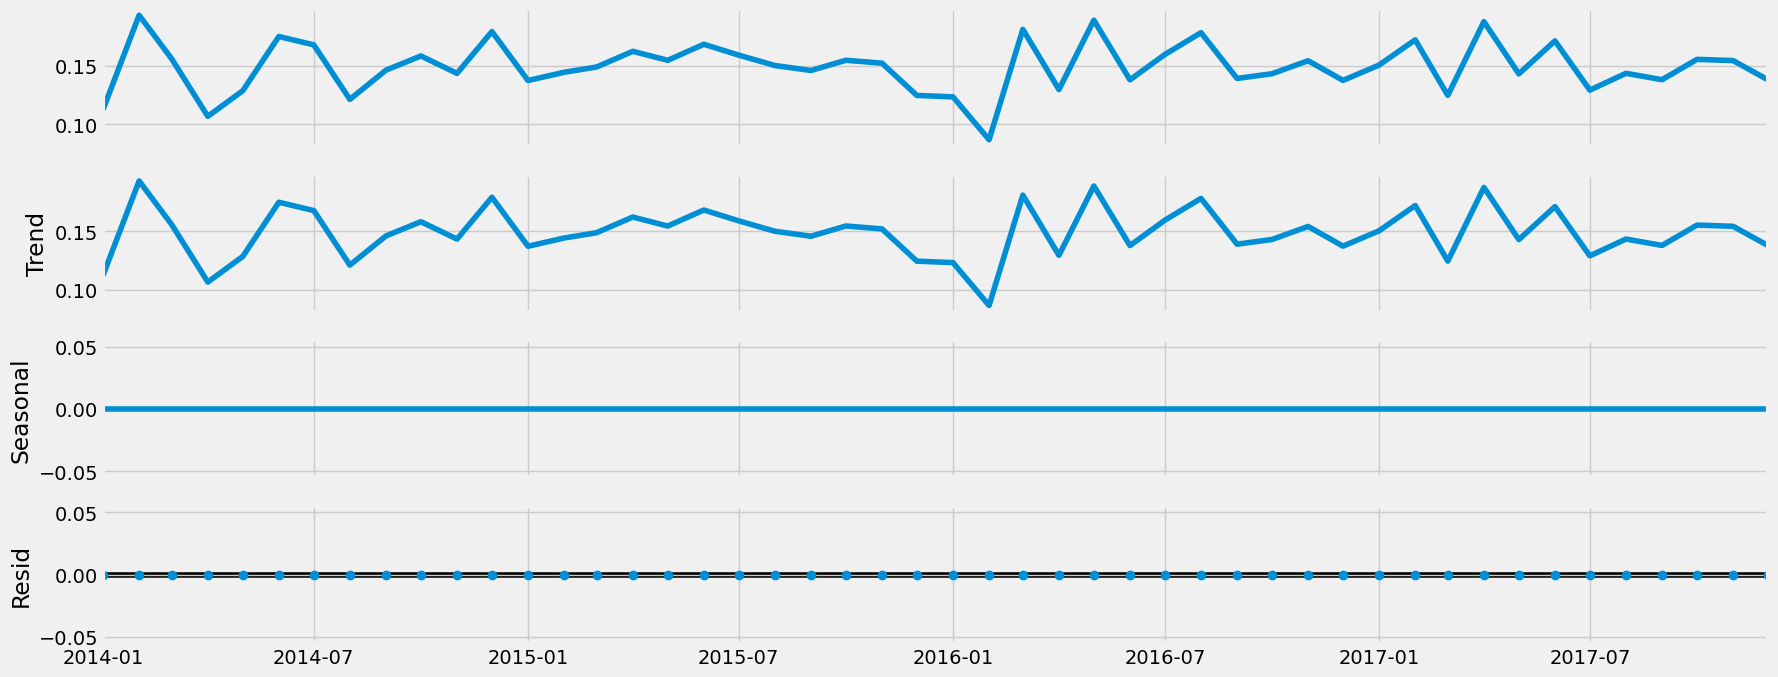

In [56]:
# Plot the separate components

decomposition.plot()
plt.show()

- Conclusions: 
There is no seasonality in the data, and the noise has been removed during Smoothing process.
The data seems to have no trend, indicating it might be starionary. Testing for stationarity is crucial.

### 4. Testing for stationarity

In [57]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(discount_per_month['Monthly_Discount'])

Dickey-Fuller Stationarity test:
Test Statistic                 -5.288238
p-value                         0.000006
Number of Lags Used             1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


- Conclusion: 
p-value is <0.05 indicating a significant result. 
Test statistic is smaller than the critical value, which means the null hypothesis can be rejected. There isn't a unit root in the data, indicating the data is stationary. An auto-correlation check is needed to confirm non-stationarity


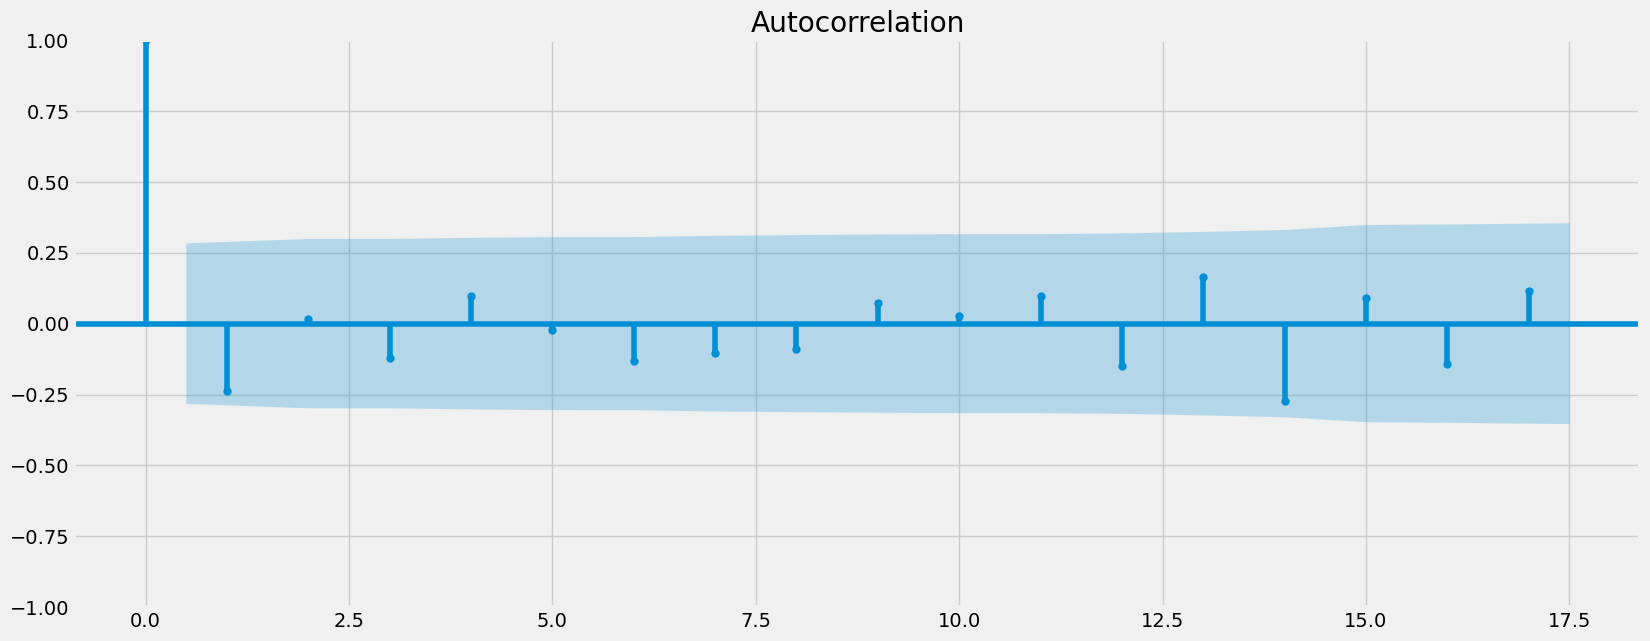

In [58]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(discount_per_month)
plt.show()

- Conclusion: there are very few vertical lines above the confidence interval, confirming the data is stationary.

## PART 2: Time series forecasting

### 1. Defining Your Parameters

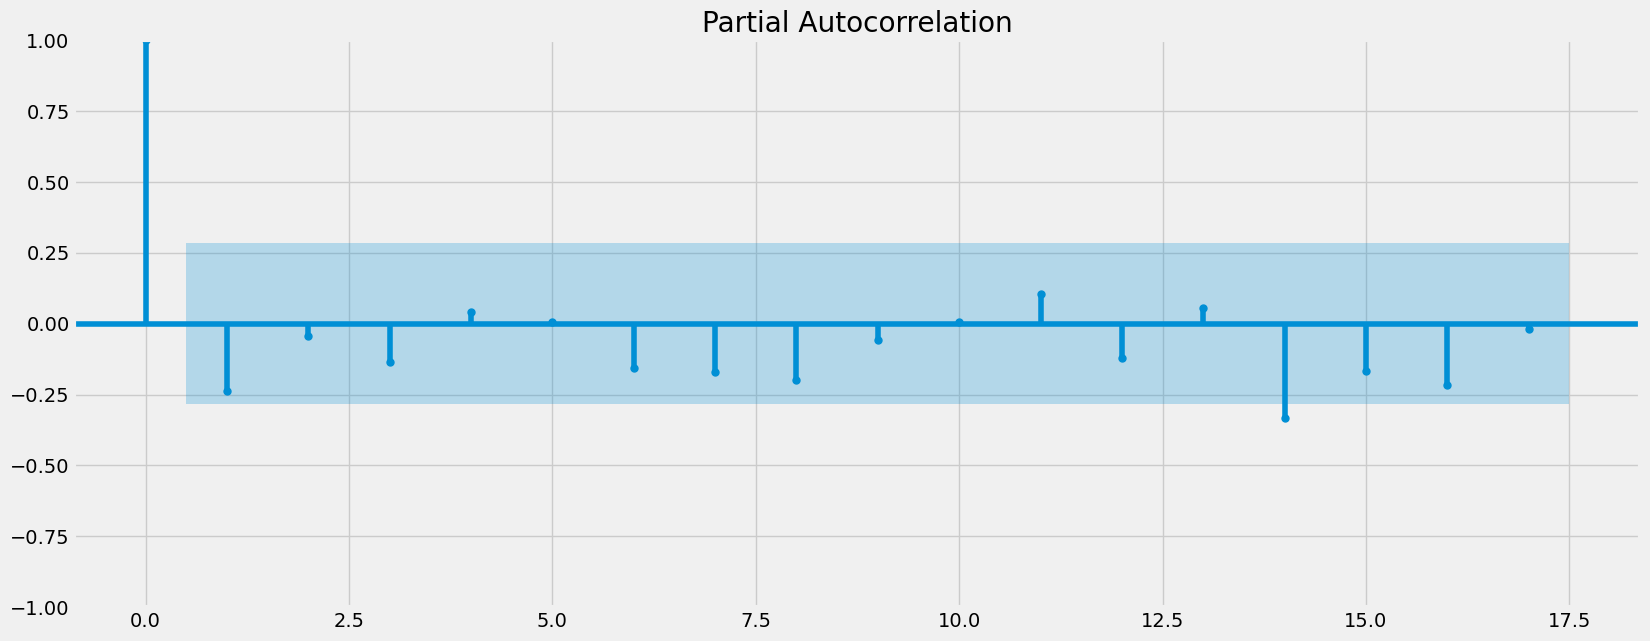

<Figure size 4500x4500 with 0 Axes>

In [59]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(discount_per_month)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

There are one highly positive bars. These indicate significant correlations. Let’s start by picking 5 AR terms to compensate for the highest of the partial autocorrelations. This makes p = 5.

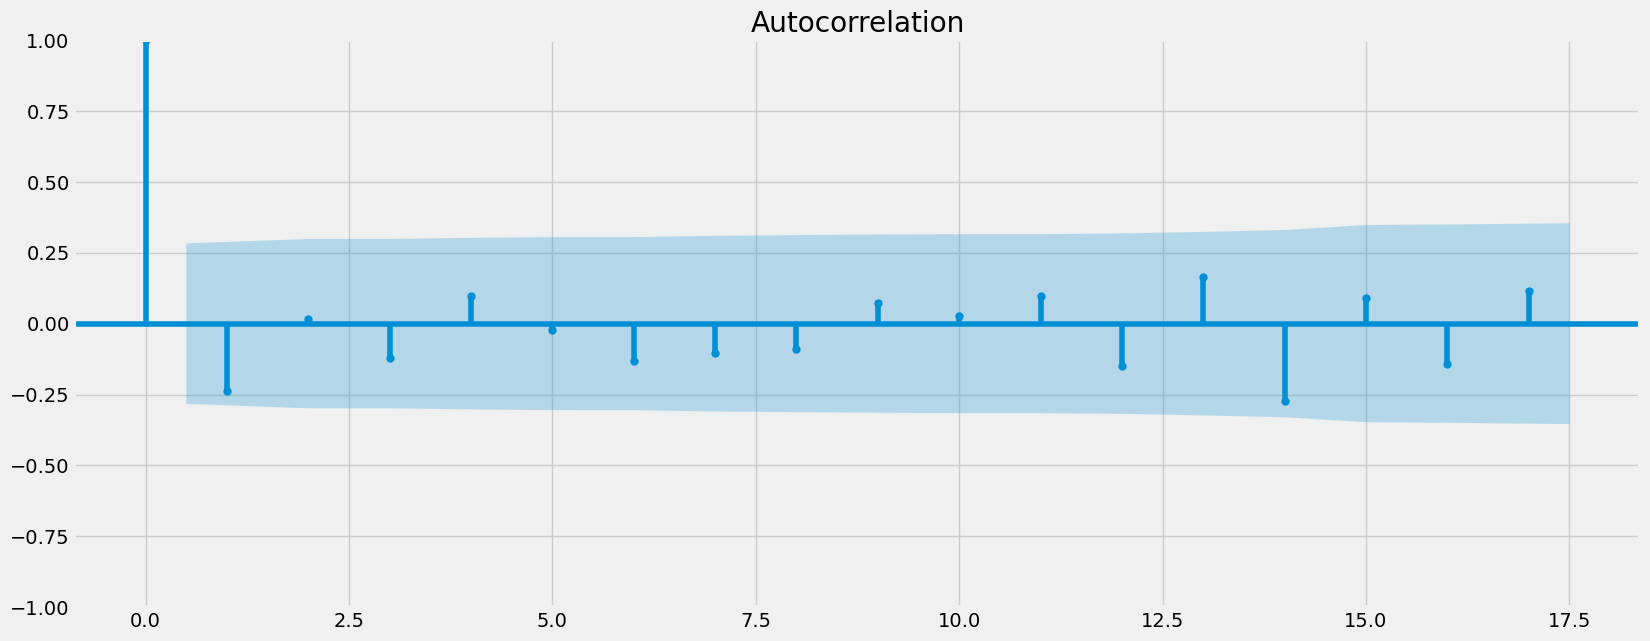

<Figure size 1500x500 with 0 Axes>

In [60]:
# Plot autocorrelations to determine parameter q

plot_acf(discount_per_month)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

q = 1

### 2. Splitting the Data

In [61]:
# Split the data

train = discount_per_month['Monthly_Discount'][:21]
test = discount_per_month['Monthly_Discount'][20:]

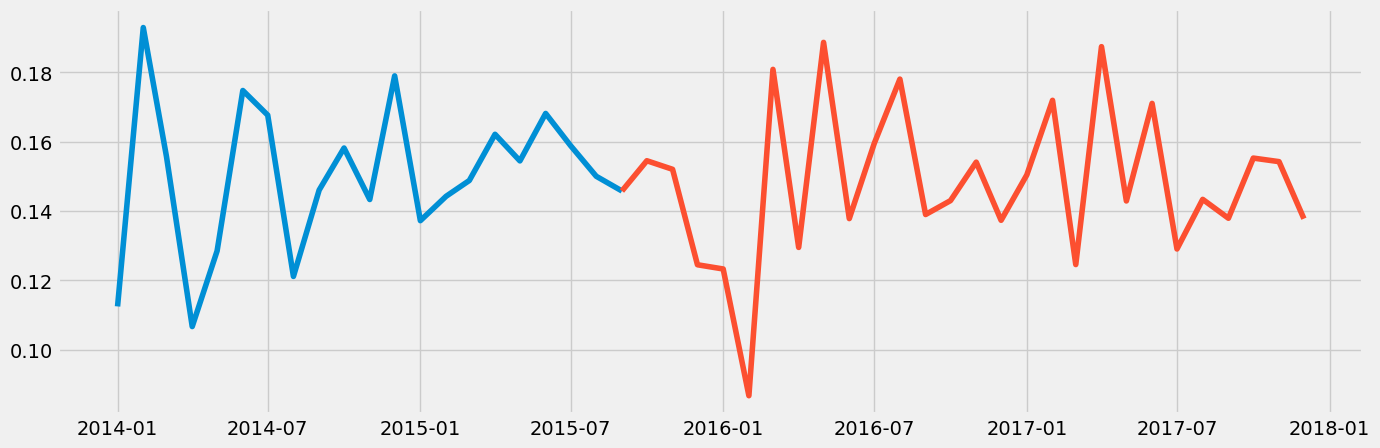

In [62]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [63]:
test.shape

(28,)

### 3. Running and Fitting the Model

In [64]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                               SARIMAX Results                                
Dep. Variable:       Monthly_Discount   No. Observations:                   21
Model:                 ARIMA(5, 1, 2)   Log Likelihood                  52.560
Date:                Sat, 27 Jan 2024   AIC                            -89.121
Time:                        08:46:58   BIC                            -81.155
Sample:                    01-01-2014   HQIC                           -87.566
                         - 09-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2497      5.416     -0.231      0.817     -11.864       9.365
ar.L2         -1.4312      2.766     -0.517      0.605      -6.853       3.991
ar.L3         -1.2385      4.555     -0.272      0.7

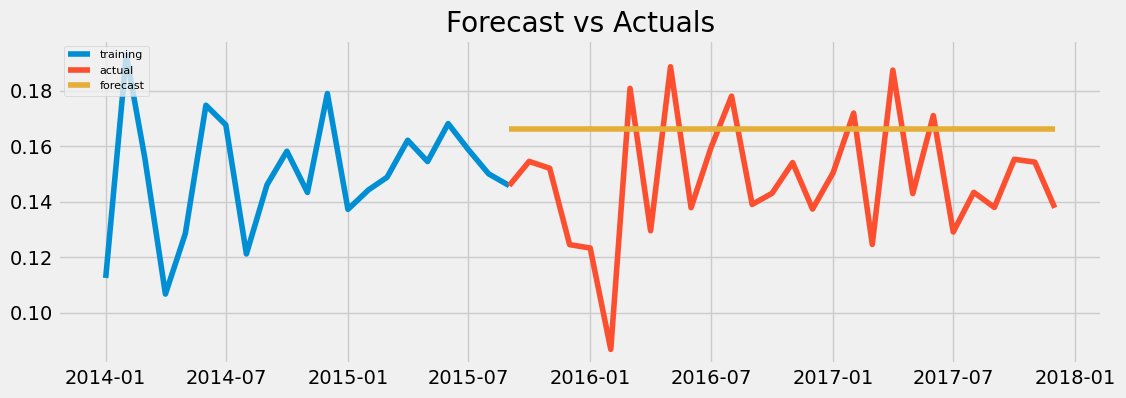

In [65]:
model = ARIMA(train, order=(5, 1, 2))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(3, 28, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4. Iterating

                               SARIMAX Results                                
Dep. Variable:       Monthly_Discount   No. Observations:                   21
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  52.309
Date:                Sat, 27 Jan 2024   AIC                            -94.617
Time:                        08:46:59   BIC                            -89.639
Sample:                    01-01-2014   HQIC                           -93.645
                         - 09-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4762      0.628     -0.758      0.448      -1.707       0.754
ar.L2         -0.8075      0.213     -3.787      0.000      -1.225      -0.390
ar.L3         -0.3910      0.531     -0.737      0.4

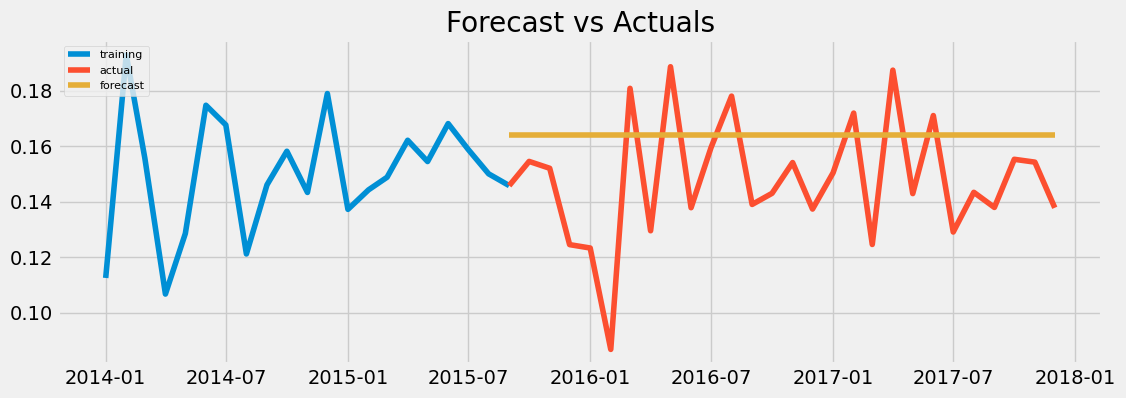

In [66]:
model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, 18, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:       Monthly_Discount   No. Observations:                   21
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  47.183
Date:                Sat, 27 Jan 2024   AIC                            -88.366
Time:                        08:46:59   BIC                            -85.379
Sample:                    01-01-2014   HQIC                           -87.783
                         - 09-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1365      0.287     -0.475      0.635      -0.700       0.427
ma.L1         -0.9771      1.958     -0.499      0.618      -4.814       2.860
sigma2         0.0005      0.001      0.536      0.5

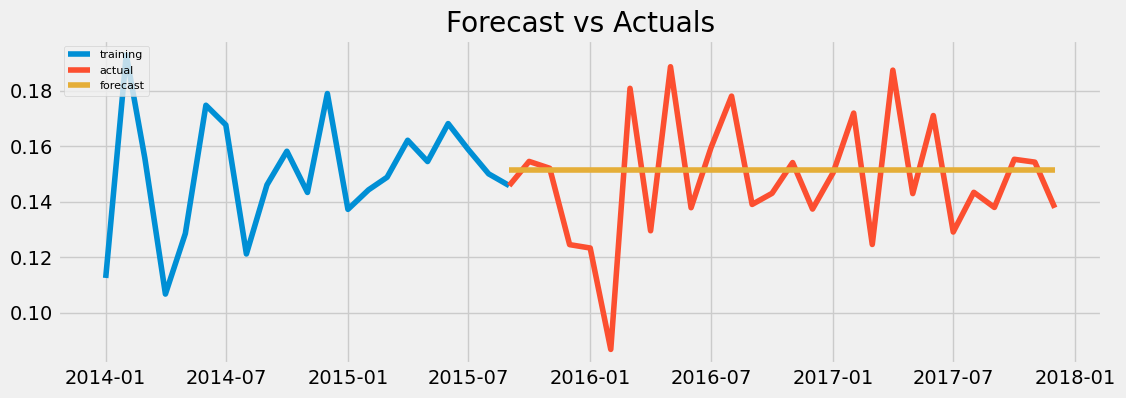

In [67]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, 18, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()